#PhlyGreen Tutorial 

Import packages

In [1]:
import sys
sys.path.insert(0,'../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
battery = pg.Systems.Battery.Battery(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, battery)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
battery.aircraft = myaircraft

Define input dictionaries

In [5]:
ConstraintsInput = {'DISA': 0.,
                    'Cruise': {'Speed': 0.34, 'Speed Type':'Mach', 'Beta': 0.95, 'Altitude': 3000.},
                    'AEO Climb': {'Speed': 130, 'Speed Type':'KCAS', 'Beta': 0.97, 'Altitude': 2000., 'ROC': 8},
                    'OEI Climb': {'Speed': 1.2*34.5, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 0., 'Climb Gradient': 0.021},
                    'Take Off': {'Speed': 90, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 100., 'kTO': 1.2, 'sTO': 950},
                    'Landing':{'Speed': 59., 'Speed Type': 'TAS', 'Altitude': 500.},
                    'Turn':{'Speed': 130, 'Speed Type': 'KCAS', 'Beta': 0.9, 'Altitude': 3000, 'Load Factor': 1.1},
                    'Ceiling':{'Speed': 0.5, 'Beta': 0.8, 'Altitude': 3500, 'HT': 0.5},
                    'Acceleration':{'Mach 1': 0.3, 'Mach 2':0.4, 'DT': 180, 'Altitude': 2800, 'Beta': 0.9}}

In [6]:
MissionInput = {'Range Mission': 2000/1.852,  #nautical miles but the input comes in km
                'Range Diversion': 145,  #nautical miles
                'Beta start': 0.97,
                'Minimum SOC': 0.2,
                'Payload Weight': 1500 ,  #Kg
                'Crew Weight': 500}  #Kg

In [7]:
argPhi = 0.1
MissionStages = {
                 'Takeoff':
                    {'Supplied Power Ratio':{'phi': argPhi}},

                 'Climb1': {'type': 'ConstantRateClimb', 'input': 
                    {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 560}, 
                    'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi }},

                 'Climb2': {'type': 'ConstantRateClimb', 'input': 
                    {'CB': 0.08, 'Speed': 120, 'StartAltitude': 560, 'EndAltitude': 1690}, 
                    'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi }},

                 'Climb3': {'type': 'ConstantRateClimb', 'input': 
                    {'CB': 0.07, 'Speed': 125, 'StartAltitude': 1690, 'EndAltitude': 3000}, 
                    'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end': argPhi }},

                 'Cruise': {'type': 'ConstantMachCruise', 'input': 
                    { 'Mach': 0.4, 'Altitude': 3000}, 
                   'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi }},

                 'Descent1': {'type': 'ConstantRateDescent', 'input':
                    {'CB': -0.04, 'Speed': 90, 'StartAltitude': 3000, 'EndAltitude': 200}, 
                    'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end': argPhi  }}}

DiversionStages = {
                   'Climb1': {'type': 'ConstantRateClimb', 'input': 
                        {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 1000}, 
                        'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi  }},

                   'Cruise': {'type': 'ConstantMachCruise', 'input':
                        { 'Mach': 0.35, 'Altitude': 1000}, 
                        'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi }},

                   'Descent1': {'type': 'ConstantRateDescent', 'input':
                        {'CB': -0.04, 'Speed': 90, 'StartAltitude': 1000, 'EndAltitude': 200}, 
                        'Supplied Power Ratio':{'phi_start': argPhi, 'phi_end':argPhi}}}

EnergyInput dictionary for the fuel and powertrain specifications

In [ ]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Contingency Fuel': 130,
                   'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Eta PMAD': 0.99,
                   'Specific Power Powertrain': [3900,7700],
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Battery': 35, 
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0
                   }

CellInput dictionary that defines the battery specifications to use. 
The cell model picks the discharge curve and cell parameters to use, the power and energy densities scale the battery model's capacity and discharge rate to fit the target density. Leave any of these as None to use the default parameters set by the Battery class. The energy density is given in Wh/kg and the power density in W/kg

In [ ]:
CellInput = {
    'Model':'Finger-Cell-Thermal',
    'SpecificPower': None,
    'SpecificEnergy': None,
    }

In [9]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}},
                    'Take Off Cl': 1.9,
                     'Landing Cl': 1.9,
                     'Minimum Cl': 0.20,
                     'Cd0': 0.017}


Import input dictionaries

In [10]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.CellModel = CellModel

Set aircraft power configuration

In [11]:
myaircraft.Configuration = 'Hybrid'
myaircraft.HybridType = 'Parallel'
myaircraft.AircraftType = 'ATR'

Set inputs

In [12]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

#Initialize Battery Configurator
myaircraft.battery.SetInput()

Either run the Constraint Analysis....

In [13]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  1710.4654654654653
Design P/W:  130.48855884475907
----------------------------------------


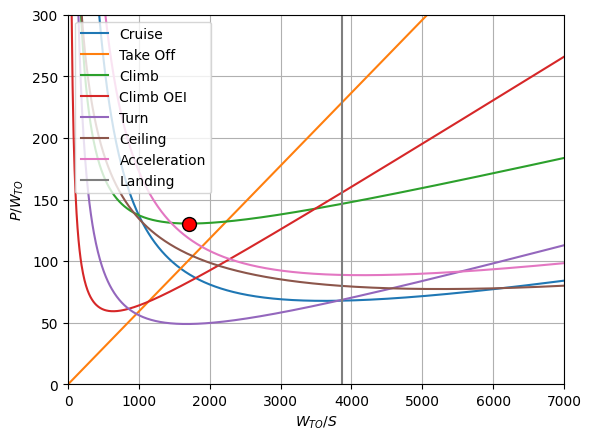

In [14]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAEOClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEIClimb, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$P/W_{TO}$')
plt.show()

... or assign a wing loading

In [15]:
# myaircraft.DesignWTOoS = 3323

Run Mission analysis to define the aircraft's masses

In [16]:
# times = np.linspace(0,myaircraft.mission.profile.MissionTime2)

# plt.plot(times,myaircraft.mission.profile.Altitude(times))
# plt.plot(827,8000,marker='s')
# plt.show()

myaircraft.weight.WeightEstimation()

Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.4362752946696378 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.438324069736911 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.454447018600361 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.4535187296312775 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.4752603666021766 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.371044833051213 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.34031323358218 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.4310126334175997 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.4676534180383856 Range: 2.5 ~ 4.2
Fail_Condition_6
Cell voltage outside of allowed range:
Voltage:2.485586735221948 Range: 2.5 ~ 4.2
Fail_C

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [17]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

A summary of the preliminary design:

In [18]:
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Battery mass [Kg]:            ', myaircraft.weight.WBat)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('TakeOff engine shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise engine shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('TakeOff battery peak power [kW]:           ', myaircraft.mission.TO_PBat/1000.)
print('Climb/cruise battery peak power [kW]:      ', myaircraft.mission.Max_PBat/1000.)
print('-------------Battery Specs-------------')
print('Battery Pack Energy [kWh]:           ', myaircraft.battery.pack_energy/3600000)
print('Battery Pack Max Power [kW]:         ', myaircraft.battery.pack_power_max/1000)
print('Battery Pack Specific Energy [Wh/kg]:',(myaircraft.battery.pack_energy/3600)/myaircraft.weight.WBat)
print('Battery Pack Specific Power [kW/kg]: ',(myaircraft.battery.pack_power_max/1000)/myaircraft.weight.WBat)
# print('Battery Configuration: ', myaircraft.battery.pack_config)
print('-------------Sizing Phase--------------')

#print('Sizing phase for battery: ', 'Cruise energy' if myaircraft.battery.energy_or_power == 'energy' else 'Cruise peak power' if myaircraft.weight.TOPwr_or_CruisePwr == 'cruise' else 'Takeoff peak power'  ) #uncomment when i add a mechanism for seeing which constraint drove what thing in the battery sizing
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
# print('Sizing phase for electric powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PBat > myaircraft.mission.TO_PBat else 'Takeoff peak power'  )

Fuel mass (trip + altn) [Kg]:  9640.829160090432
Block Fuel mass [Kg]:          9770.829160090432
Battery mass [Kg]:             18931.44
Structure [Kg]:                34194.56375341811
Powertrain mass [Kg]:          1685.4509137293226
Empty Weight [Kg]:             55311.45466714742
Zero Fuel Weight [Kg]:         56811.45466714742
----------------------------------------
Takeoff Weight:  66582.31768091481
Wing Surface:  381.8682982132164  m^2
TakeOff engine shaft peak power [kW]:       5234.299595727425
Climb/cruise engine shaft peak power [kW]:  -0.001
TakeOff battery peak power [kW]:            2643.5856544077906
Climb/cruise battery peak power [kW]:       -0.001
-------------Battery Specs-------------
Battery Pack Energy [kWh]:            7.947353333333334
Battery Pack Max Power [kW]:          -50194.67874265928
Battery Pack Specific Energy [Wh/kg]: 0.41979655712050085
Battery Pack Specific Power [kW/kg]:  -2.651392537633655
-------------Sizing Phase--------------
Sizing phase for

Some plots:

[np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.

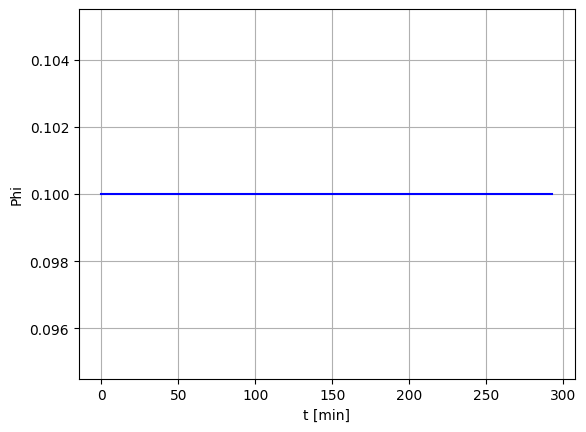

In [19]:
times = np.linspace(0,mission.profile.MissionTime2,num = 1000)
plt.plot(times/60,[mission.profile.SuppliedPowerRatio(t) for t in times], 'b')
print([mission.profile.SuppliedPowerRatio(t) for t in times])
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Phi')
plt.show()

In [20]:
times = np.array([])
Ef    = np.array([])
Ebat  = np.array([])
beta  = np.array([])
soc   = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef    = np.concatenate([Ef   , array.y[0]])
    Ebat  = np.concatenate([Ebat , array.y[1]])
    beta  = np.concatenate([beta , array.y[2]])
    soc   = np.concatenate([soc  , array.y[3]])

Takeoff propulsive power

In [21]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.TakeOffConstraints['Beta'], myaircraft.constraint.TakeOffConstraints['Altitude'],myaircraft.constraint.TakeOffConstraints['kTO'], myaircraft.constraint.TakeOffConstraints['sTO'], myaircraft.constraint.DISA, myaircraft.constraint.TakeOffConstraints['Speed'], myaircraft.constraint.TakeOffConstraints['Speed Type'])

np.float64(101.20454232421957)

Maximum mission Propusive Power over Takeoff Mass

In [22]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

np.float64(194.97367848215342)

Battery Stats

In [23]:
print("Final SOC:",soc[-1])
#print("")

Final SOC: 83256850.00087959


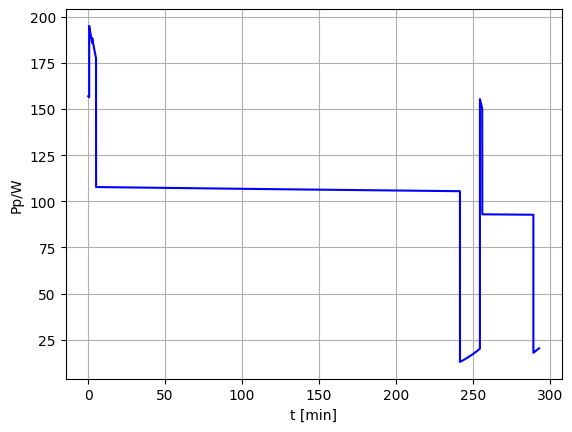

In [24]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

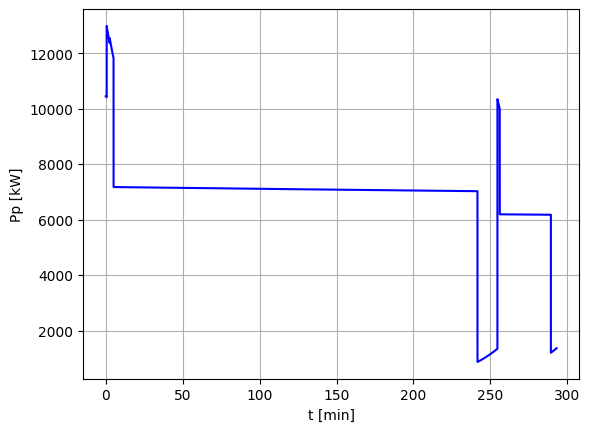

[0.00000000e+00 3.63591706e-09 7.27183412e-09 4.36310047e-08
 7.99901753e-08 4.43581881e-07 8.07173587e-07 4.44309064e-06
 8.07900770e-06 4.44381783e-05 8.07973489e-05 4.44389055e-04
 8.07980760e-04 4.44389782e-03 8.07981488e-03 4.44389855e-02
 8.07981560e-02 1.17157327e-01 4.80749032e-01 8.44340738e-01
 1.20793244e+00 4.84384950e+00 8.47976656e+00 1.21156836e+01
 2.65380491e+01 2.88304393e+01 3.11228295e+01 3.34152196e+01
 3.57076098e+01 3.63794037e+01 3.70511976e+01 3.77229916e+01
 3.78604441e+01 3.79978966e+01 3.80000000e+01 3.80000000e+01
 3.80019796e+01 3.80039591e+01 3.80237548e+01 3.80435506e+01
 3.82415076e+01 3.84394647e+01 4.02366843e+01 4.20339039e+01
 4.38311235e+01 5.37364552e+01 6.36417869e+01 7.35471187e+01
 9.80825231e+01 1.22617928e+02 1.47153332e+02 1.52426716e+02
 1.55096151e+02 1.56000000e+02 1.56000000e+02 1.56004396e+02
 1.56008792e+02 1.56052751e+02 1.56096711e+02 1.56536307e+02
 1.56975902e+02 1.60963944e+02 1.64951985e+02 1.68940027e+02
 1.89685314e+02 2.104306

In [ ]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp [kW]')
plt.show()

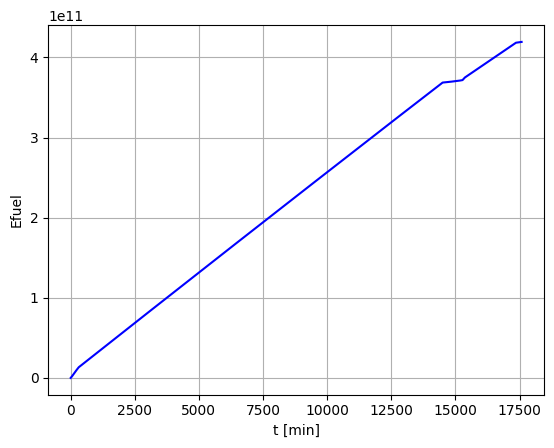

In [26]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

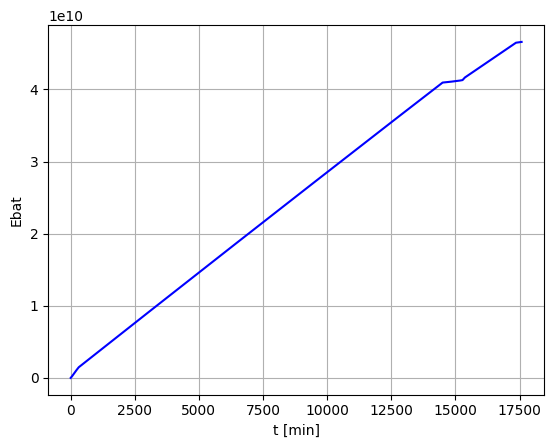

In [27]:
plt.plot(times,Ebat, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Ebat')
plt.show()

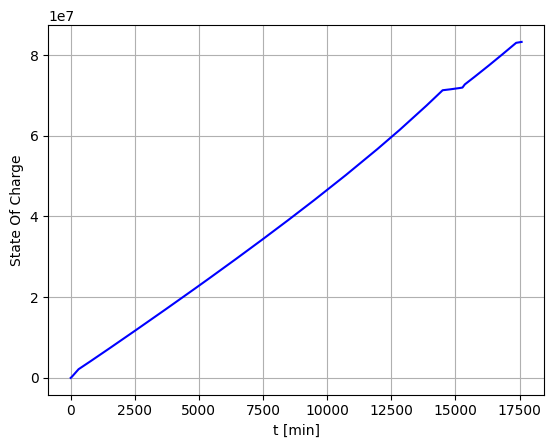

In [28]:
plt.plot(times,soc, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('State Of Charge')
plt.show()

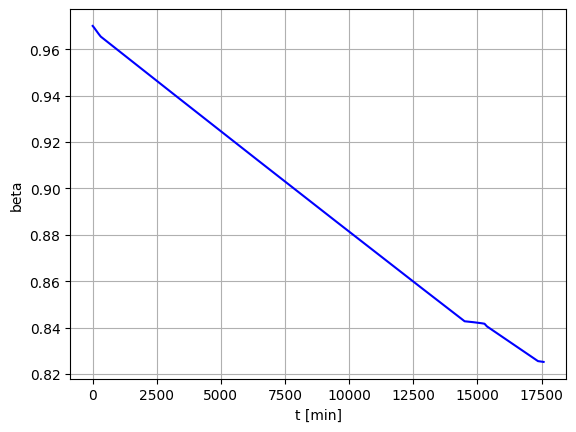

In [29]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

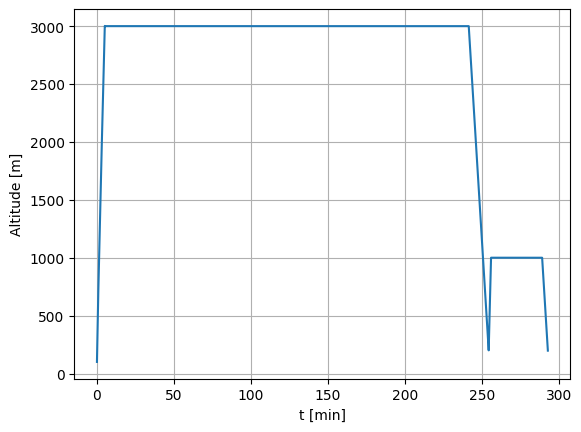

In [30]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()